##### **Analyse Sentinel-2 data**

See the [data getter](get_sentinel_data.ipynb) for further details on how the data was downloaded, which includes a degree of pre-processing.

In [1]:
from IPython.display import display, HTML

import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm

import plotly.express as px

import multiprocessing

from sklearn.utils import shuffle

from collections import OrderedDict, defaultdict

from dython.nominal import associations

import sentinel_utils
import importlib
importlib.reload(sentinel_utils)
from sentinel_utils import SentinelUtils

In [2]:
parent_dir = Path.home().joinpath('sentinel_data')
shards_dir = parent_dir.joinpath('shards')

data_tag = '2017'
features_dir = shards_dir.joinpath(f'features_{data_tag}')
labels_dir = shards_dir.joinpath(f'labels_{data_tag}')

sort_key = lambda x: int(x.stem.split('_')[-1])
feature_shards = sorted(list(features_dir.glob('feature_*.npy')), key=sort_key)
label_shards = sorted(list(labels_dir.glob('label_*.npy')), key=sort_key)

In [3]:
sample_shards = 50000
p = SentinelUtils(
    shuffle(feature_shards, random_state=42)[:sample_shards],
    label_shards, min_occurrences=5000, 
    overwrite_summary=False, overwrite_selection=False
)

These are the bands that have been downloaded. It follows the same order as the data structure.

In [4]:
tci_bands = OrderedDict(zip(['TCI_R', 'TCI_G', 'TCI_B'], ['red', 'green', 'blue']))
bgr_bands = OrderedDict(zip(['B2', 'B3', 'B4'], ['#00ffb5', '#c3ff00', '#ff0000']))
nir_bands = OrderedDict(zip(['B5', 'B6', 'B7', 'B8', 'B8A'],px.colors.cyclical.Twilight[:5]))
swir_bands = OrderedDict(zip(['B11', 'B12'], px.colors.qualitative.Plotly[:2]))
all_bands = bgr_bands | nir_bands | swir_bands | tci_bands

In [14]:
def get_band_samples(pixels_per, feature_shards):
    band_samples = {k: [] for k in all_bands}
    for f in tqdm(feature_shards):
        data = np.load(f)
        for i, band in enumerate(all_bands):
            random_sample = shuffle(data[..., i].flatten(), random_state=42)[:pixels_per]
            band_samples[band].extend(random_sample)
    return band_samples
band_samples = get_band_samples(50, shuffle(feature_shards, random_state=42)[:1000])

  0%|          | 0/1000 [00:00<?, ?it/s]

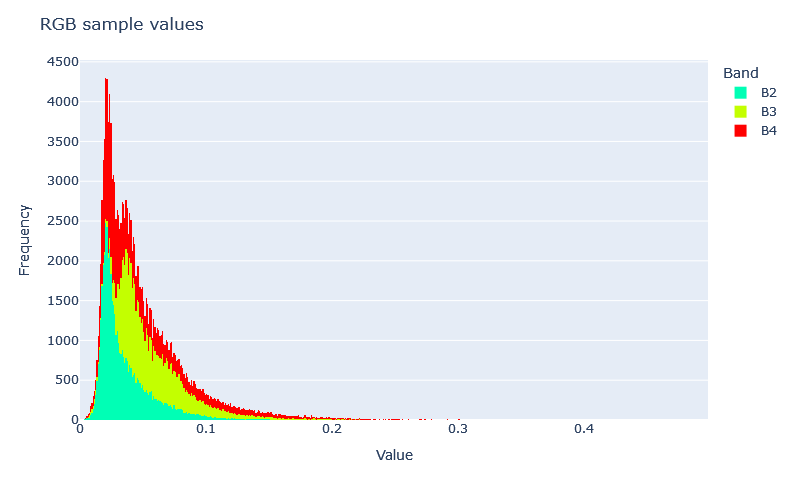

In [15]:
fig1 = px.histogram(
    {k: band_samples[k] for k in bgr_bands}, 
    color_discrete_map=bgr_bands).update_layout(
    xaxis_title='Value', yaxis_title="Frequency", title='RGB sample values',
    legend_title_text='Band', height=500
)
display(fig1)

In [ ]:
fig1 = px.histogram({k: band_samples[k] for k in tci_bands}, 
             color_discrete_map=tci_bands).update_layout(
    xaxis_title='Value', yaxis_title="Frequency", title='True color sample values',
    legend_title_text='Band', height=500
)

In [ ]:
fig1 = px.histogram({k: band_samples[k] for k in nir_bands}, 
             color_discrete_map=nir_bands).update_layout(
    xaxis_title='Value', yaxis_title="Frequency", 
    title='Red edge and NIR sample values',
    legend_title_text='Band', height=500
)

fig2 = px.histogram({k: SentinelUtils().zscore_normalise_X(np.array(band_samples[k]), mean[k], p.data_summary['std'][k]) for k in nir_bands}, 
             color_discrete_map=nir_bands).update_layout(
    xaxis_title='Value', yaxis_title="Frequency", 
    title='Z-score normalised edge and NIR sample values',
    legend_title_text='Band', height=500
)

fig3 = px.histogram({k: SentinelUtils().minmax_normalise_X(np.array(band_samples[k]), p1_min[k], p1_max[k], mean[k]) for k in nir_bands}, 
             color_discrete_map=nir_bands).update_layout(
    xaxis_title='Value', yaxis_title="Frequency", 
    title='Percentile min-max normalised edge and NIR sample values',
    legend_title_text='Band', height=500
)

display(fig1, fig2, fig3)

In [ ]:
fig1 = px.histogram({k: band_samples[k] for k in swir_bands}, 
             color_discrete_map=swir_bands).update_layout(
    xaxis_title='Value', yaxis_title="Frequency", 
    title='Short-wave infrared sample values',
    legend_title_text='Band', height=500
)

fig2 = px.histogram({k: SentinelUtils().zscore_normalise_X(np.array(band_samples[k]), mean[k], p.data_summary['std'][k]) for k in swir_bands}, 
             color_discrete_map=swir_bands).update_layout(
    xaxis_title='Value', yaxis_title="Frequency", 
    title='Z-score normalised short-wave infrared sample values',
    legend_title_text='Band', height=500
)

fig3 = px.histogram({k: SentinelUtils().minmax_normalise_X(np.array(band_samples[k]), p1_min[k], p1_max[k], mean[k]) for k in swir_bands}, 
             color_discrete_map=swir_bands).update_layout(
    xaxis_title='Value', yaxis_title="Frequency", 
    title='Percentile min-max normalised short-wave infrared sample values',
    legend_title_text='Band', height=500
)

display(fig1, fig2, fig3)

The bands display positively skewed distributions. To mitigate this issue, the values are normalised using the 1st and 99th quartiles instead of the min and max values. To reduce skewedness, values outside the quartiles are replaced with medians.

In [ ]:
min_occurrence = 5000 # change to 0 for entire dataset
selected_shards, selected_columns = SentinelUtils().select_occurrences(labels_filepaths, min_occurrence)

In [ ]:
len(selected_shards) / min_occurrence

Use min_occurence to guide the choice of $batch_size$. That is, $samples / min\_occurrence$ gives the minimum $batch\_size$ where at least one sample from the minority class is expected, on average, to appear in a batch. For $samples=250,000$ and $min\_occurrence = 5,000$, $batch\_size_{min}=50$.

Get a few samples and display a few images as an animation.

In [ ]:
def get_sample_images(sample_ids):
    plots = pd.read_csv('plots.csv')
    std = list(np.load(samples_dir.joinpath('std.npy'), allow_pickle=True).item().values())
    mean = list(np.load(samples_dir.joinpath('mean.npy'), allow_pickle=True).item().values())
    
    features = []
    labels = []
    for sample_id in sample_ids:
        features.append(np.load(shards_dir.joinpath(f'feature_{sample_id}.npy')))
        labels.append(plots.iloc[sample_id]['SPECIES NAME'])

    rgb = np.stack(features)
    rgb = rgb * np.array(std) + np.array(mean)
    rgb = rgb[..., -3:]
    return rgb, np.vstack(labels)

n_samples = 50
ids = [int(s.stem.split('_')[-1]) for s in shards_dir.glob(f'feature_*.npy')]
sample_ids = shuffle(ids, random_state=42)[:n_samples] 
rgb, labels = get_sample_images(sample_ids)

In [ ]:
def visualise_grid(rgb, labels):
    fig = px.imshow(rgb, 
                    animation_frame=0, height=500, width=500
                   )
    for frame_name, step in zip(labels, fig.layout.sliders[0].steps):
        step.label = ','.join(frame_name)
    
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    fig.update_layout(margin={'t':0,'l':0,'b':0,'r':0})
    return fig

# visualise_grid(rgb, labels)

Perform a correlation analysis. In order to do this, either flatten the images into a 2d array or take the means of the 36 pixels.

In [ ]:
def calculate_corrs(filepaths, all_bands, target_df, method_means=False):
    corrs = []
    for filepath in tqdm(filepaths):
        with open(filepath, 'rb') as f:
            data = np.load(filepath)
            if method_means:
                df = pd.DataFrame(np.mean(data, axis=(1, 2)), columns=all_bands)
                df['target'] = target_df.astype('category').values
            else:
                df = pd.DataFrame(data.reshape(-1, len(all_bands)), columns=all_bands)
                df['target'] = target_column.astype('category').repeat(10000).values
            
            corrs.append(associations(df, compute_only=True)['corr'].round(1))
    return corrs

For further details: http://shakedzy.xyz/dython/

In [ ]:
# corrs = calculate_corrs(filepaths, all_bands, df, method_means=False)
# fig = px.imshow(
#     np.array(corrs),
#     animation_frame=0,
#     labels=dict(color="Corr coef"),
#     x=corrs[0].index,
#     y=corrs[0].columns,
#     title='Seasonal correlation heatmap',
#     text_auto=True, aspect='auto', zmin=0, height=500
# )
# for season, step in zip([s.stem for s in seasonal_paths], fig.layout.sliders[0].steps):
#     step.label = season

# fig